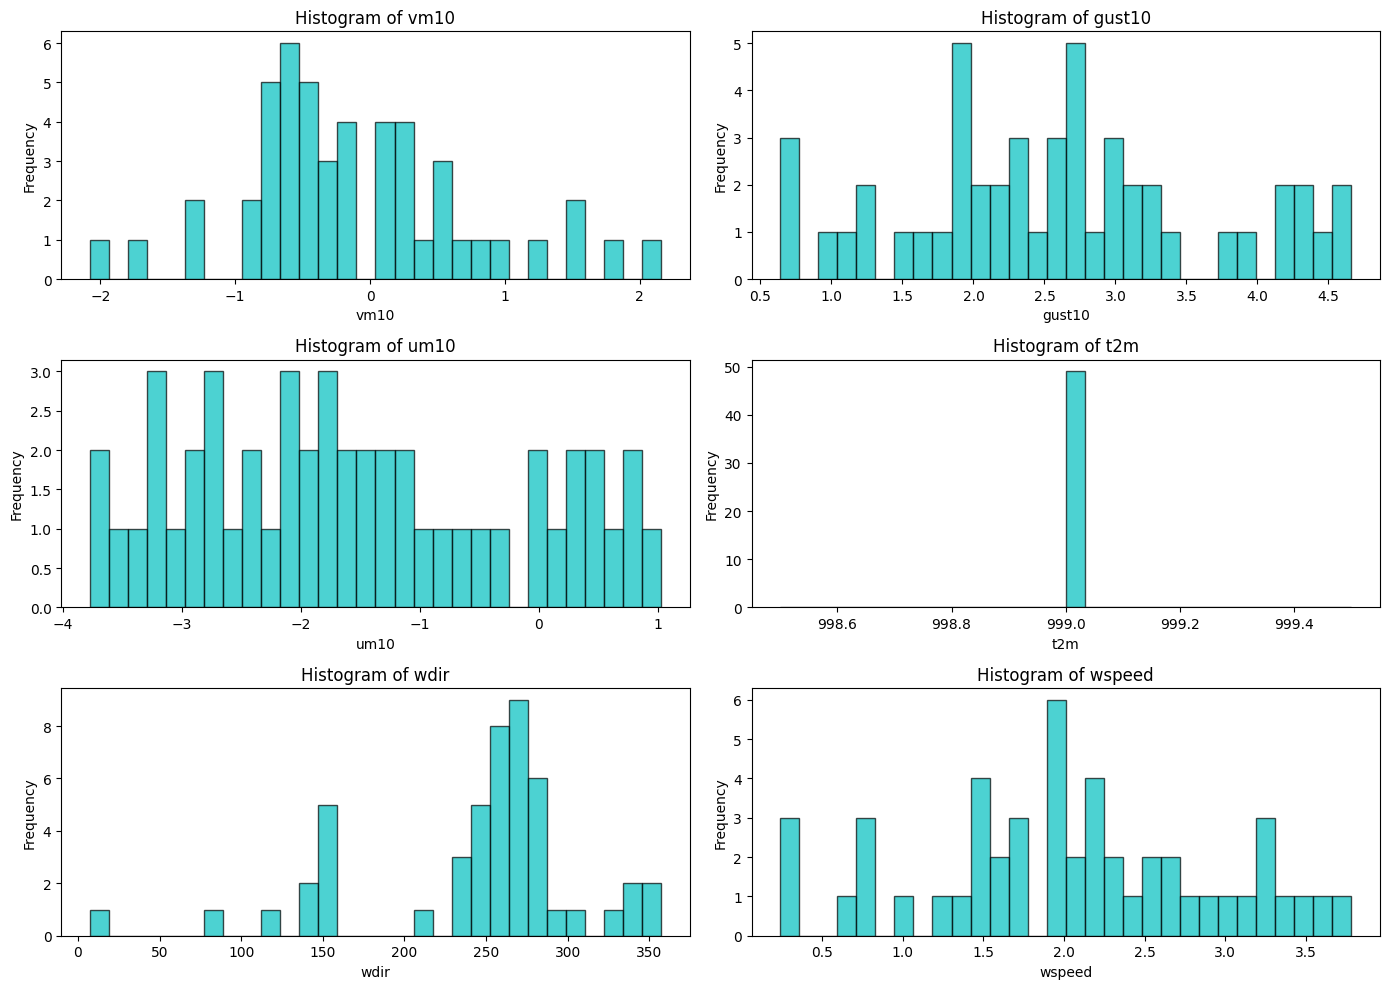

         vm10    gust10      um10    t2m        wdir    wspeed
min -2.077934  0.638577 -3.770890  999.0    7.317467  0.238577
max  2.157765  4.662214  1.028886  999.0  357.194190  3.782964
std  0.855370  1.066369  1.370464    0.0   69.616494  0.906950


In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import cftime 
from datetime import datetime

# Suppress warnings if you prefer not to see them
warnings.filterwarnings("ignore", category=UserWarning, append=True)

def load_mesonh_data(fileinput, lat, lon, parameters_to_plot):
    # Open the MESONH dataset with decode_times=False to avoid issues with non-standard time units
    ds = xr.open_dataset(fileinput, decode_times=False)
    
    # Extract the time variable
    time_var = ds["time"]

    # Get the time units, and remove the non-standard prefix
    units = time_var.attrs['units'].replace('fire ignition: ', '')

    # Convert the time variable using cftime
    times = cftime.num2date(time_var.values, units=units, calendar='standard')

    # Convert to pandas datetime if needed
    times_as_datetime = [datetime(year=t.year, month=t.month, day=t.day, 
                                  hour=t.hour, minute=t.minute, second=t.second,
                                  microsecond=t.microsecond) for t in times]

    # Replace the time variable in the dataset with the converted times
    ds["time"] = ("time", times_as_datetime)
    
    # Calculate the squared distance to each grid point for lat and lon
    lat_diff = (ds['y'] - lat)**2  # MESONH uses 'y' for latitude
    lon_diff = (ds['x'] - lon)**2  # MESONH uses 'x' for longitude
    dist = np.sqrt(lat_diff + lon_diff)
    
    # Find the indices of the minimum distance
    x_idx, y_idx = np.unravel_index(dist.argmin(), dist.shape)

    # Extract data at the closest grid point
    data_at_point = ds[parameters_to_plot].isel(x=x_idx, y=y_idx).to_dataframe().reset_index()

    # Calculate wind speed and direction
    data_at_point['wdir'] = (np.arctan2(data_at_point['um10'], data_at_point['vm10']) * 180 / np.pi + 360) % 360
    data_at_point['wspeed'] = np.sqrt(data_at_point['um10']**2 + data_at_point['vm10']**2)

    return data_at_point

# Function to plot histograms for the selected parameters with dynamic grid layout
def plot_histograms(df, parameters):
    num_params = len(parameters)
    
    # Determine the number of rows and columns needed for subplots
    ncols = 2  # Set number of columns to 2
    nrows = (num_params + 1) // ncols  # Calculate the number of rows needed
    
    plt.figure(figsize=(14, 10))
    
    # Loop over the parameters and create subplots dynamically
    for i, param in enumerate(parameters, 1):
        if param in df.columns:
            plt.subplot(nrows, ncols, i)
            plt.hist(df[param].dropna(), bins=30, color='c', edgecolor='k', alpha=0.7)
            plt.title(f'Histogram of {param}')
            plt.xlabel(param)
            plt.ylabel('Frequency')
        else:
            print(f"Warning: {param} not found in the DataFrame columns.")
    
    plt.tight_layout()
    plt.show()

# Function to calculate statistics for selected parameters
def calculate_statistics(df, parameters):
    stats = {}
    
    for param in parameters:
        if param in df.columns:
            min_val = df[param].min()
            max_val = df[param].max()
            std_val = df[param].std()
            
            stats[param] = {
                'min': min_val,
                'max': max_val,
                'std': std_val
            }
        else:
            print(f"Warning: {param} not found in the DataFrame columns.")
    
    return pd.DataFrame(stats)

# Example usage
file_path = '/data/IMFSE/PythonCourse/MNH/FCAST_model1.nc'  # Replace with your actual file path
lat = 41.709377863541654
lon = 1.892273844304144

# Load data from the MESONH file
parameters_to_plot = ['vm10', 'gust10', 'um10', 't2m']
mesonh_data = load_mesonh_data(file_path, lat, lon, parameters_to_plot)

# Save the data to a CSV file
mesonh_data.to_csv('mesonh_data.csv', index=False)

# Plot histograms
plot_histograms(mesonh_data, parameters_to_plot + ['wdir', 'wspeed'])

# Calculate statistics for the parameters
parameters_to_analyze = ['vm10', 'gust10', 'um10', 't2m', 'wdir', 'wspeed']
statistics = calculate_statistics(mesonh_data, parameters_to_analyze)

# Display the statistics
print(statistics)
